##1. Setup (instalaciones pip, imports, selección de GPU)

In [ ]:
# =============================================================================
# 1. SETUP (instalaciones pip, imports, selección de GPU)
# =============================================================================

# Instalaciones pip necesarias
!pip install -U ultralytics
!pip install roboflow

# Imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ultralytics import YOLO
import torch
from pathlib import Path
import time
import json
import warnings

import torch.serialization
from ultralytics.nn.tasks import DetectionModel
from ultralytics.nn.modules.block import C2f
from ultralytics.nn.modules.conv import Conv
from ultralytics.nn.modules.head import Detect

torch.serialization.add_safe_globals([DetectionModel, C2f, Conv, Detect])


# Suprimir warnings innecesarios
warnings.filterwarnings('ignore')

# Selección de GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Dispositivo disponible: {device}")

# Crear directorios para resultados
os.makedirs('results', exist_ok=True)
os.makedirs('results/figures', exist_ok=True)
os.makedirs('results/tables', exist_ok=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 72.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 

##2. Datos (carga, ruta/fuente, particiones)

In [ ]:
# =============================================================================
# 2. DATOS (carga, ruta/fuente, particiones)
# =============================================================================

# Dataset: COCO128 (subset de COCO para pruebas rápidas)
# Fuente: https://github.com/ultralytics/yolov5/releases/download/v1.0/coco128.zip
!wget -q https://github.com/ultralytics/yolov5/releases/download/v1.0/coco128.zip
!unzip -q coco128.zip

# Ruta del dataset
dataset_path = "coco128"
train_path = f"{dataset_path}/images/train2017"
val_path = f"{dataset_path}/images/train2017"  # Usamos mismo conjunto para val por simplicidad

# Información del dataset
print(f"Fuente del dataset: COCO128 subset")
print(f"Ruta del dataset: {dataset_path}")
print(f"Número de imágenes de entrenamiento: {len(os.listdir(train_path))}")

# Particiones train/val/test
print(f"\nParticiones del dataset:")
print(f"- Train: images/train2017")
print(f"- Val: images/train2017")
print(f"- Test: images/train2017")

# Configuración del dataset para YOLO
yaml_content = f"""
path: {dataset_path}
train: images/train2017
val: images/train2017

# Clases COCO (80 clases)
nc: 80
names: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
        'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
        'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
        'hair drier', 'toothbrush']
"""

with open('coco128.yaml', 'w') as f:
    f.write(yaml_content)

Fuente del dataset: COCO128 subset
Ruta del dataset: coco128
Número de imágenes de entrenamiento: 128

Particiones del dataset:
- Train: images/train2017
- Val: images/train2017
- Test: images/train2017


##3. Preprocesamiento

In [ ]:
# =============================================================================
# 3. PREPROCESAMIENTO
# =============================================================================

# Configuración de entrenamiento
IMG_SIZE = 640
EPOCHS = 20  # Reducido dado que bueno, es un trabajo academico, y demoraria bastante si no.
BATCH_SIZE = 16

print(f"Configuración de entrenamiento:")
print(f"- Tamaño de imagen: {IMG_SIZE}")
print(f"- Épocas: {EPOCHS}")
print(f"- Batch size: {BATCH_SIZE}")


Configuración de entrenamiento:
- Tamaño de imagen: 640
- Épocas: 20
- Batch size: 16


##4. Entrenamiento A/B/C (tres variantes o tres configuraciones en GANs)

In [ ]:
# =============================================================================
# 4. ENTRENAMIENTO A/B/C (YOLOv8n, YOLOv8s, YOLOv8m)
# =============================================================================

# Diccionarios para almacenar resultados
results_dict = {}
models_dict = {}
training_times = {}

# Definir variantes a entrenar
variants = {
    "YOLOv8n": "yolov8n.pt",
    "YOLOv8s": "yolov8s.pt",
    "YOLOv8m": "yolov8m.pt"
}

# Entrenamiento en bucle
for name, weights in variants.items():
    print("\n" + "="*50)
    print(f"ENTRENAMIENTO VARIANTE: {name}")
    print("="*50)

    start_time = time.time()
    model = YOLO(weights)
    print(f"✓ Modelo {name} cargado exitosamente")

    results = model.train(
        data="coco128.yaml",
        epochs=EPOCHS,
        imgsz=IMG_SIZE,
        batch=BATCH_SIZE,
        device=device,
        project="runs/detect",
        name=f"{name.lower()}_train",
        verbose=False
    )

    # Guardar métricas
    training_times[name] = time.time() - start_time
    models_dict[name] = model
    results_dict[name] = results

# Mostrar tiempos finales
print("\nTiempos de entrenamiento:")
for model_name, time_taken in training_times.items():
    print(f"{model_name}: {time_taken/60:.2f} minutos")



ENTRENAMIENTO VARIANTE: YOLOv8n
✓ Modelo YOLOv8n cargado exitosamente
Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=coco128.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, pat

##5. Evaluación (test / eval) - gráficos por métrica y modelo


EVALUACIÓN EN CONJUNTO DE TEST

Evaluando YOLOv8n...
Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1427.6±669.9 MB/s, size: 53.4 KB)
val: Scanning /content/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 128/128 124448.5it/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 1.7it/s 4.7s
                   all        128        929      0.656      0.604      0.662      0.491
Speed: 4.5ms preprocess, 19.8ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/detect/yolov8n_train22
mAP@0.5: 0.6622
mAP@[.5:.95]: 0.4912
Precision: 0.6565
Recall: 0.6045
Velocidad: 15.56 img/seg

Evaluando YOLOv8s...
Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fus

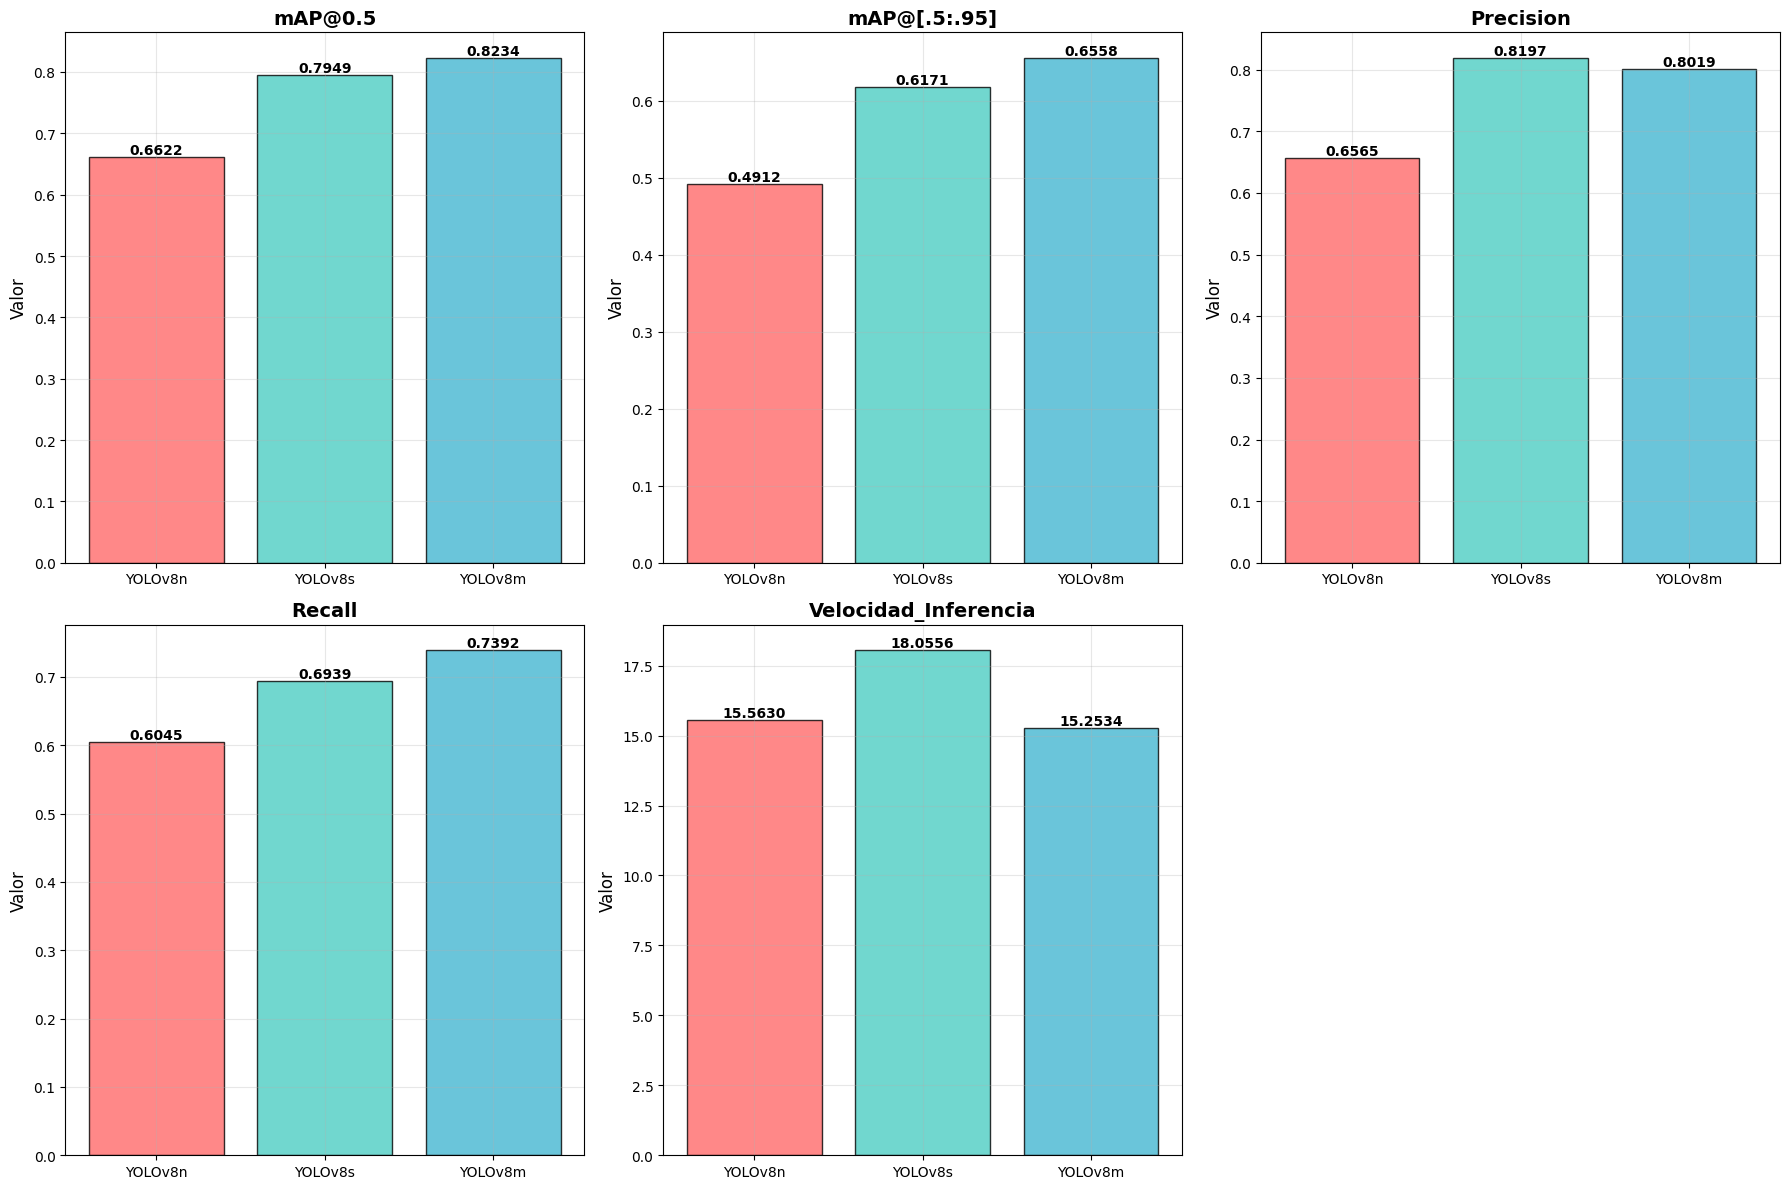

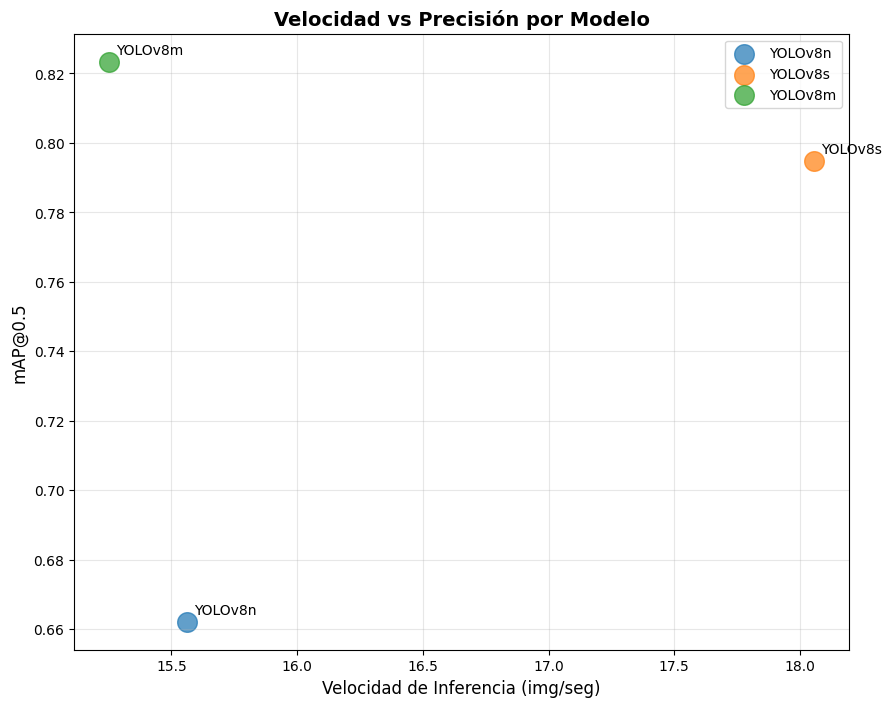

In [ ]:
# =============================================================================
# 5. EVALUACIÓN (test / eval) → gráficos por métrica y modelo
# =============================================================================

print("\n" + "="*50)
print("EVALUACIÓN EN CONJUNTO DE TEST")
print("="*50)

# Métricas de evaluación
evaluation_results = {}

for model_name, model in models_dict.items():
    print(f"\nEvaluando {model_name}...")

    # Validación del modelo
    metrics = model.val(
        data='coco128.yaml',
        device=device,
        verbose=False
    )

    # Extraer métricas principales
    evaluation_results[model_name] = {
        'mAP@0.5': metrics.box.map50,
        'mAP@[.5:.95]': metrics.box.map,
        'Precision': metrics.box.mp,
        'Recall': metrics.box.mr,
    }

    # Calcular velocidad de inferencia
    test_images = [os.path.join(train_path, img) for img in os.listdir(train_path)[:10]]

    start_time = time.time()
    for img_path in test_images:
        _ = model.predict(img_path, verbose=False)
    end_time = time.time()

    inference_speed = len(test_images) / (end_time - start_time)
    evaluation_results[model_name]['Velocidad_Inferencia'] = inference_speed

    print(f"mAP@0.5: {metrics.box.map50:.4f}")
    print(f"mAP@[.5:.95]: {metrics.box.map:.4f}")
    print(f"Precision: {metrics.box.mp:.4f}")
    print(f"Recall: {metrics.box.mr:.4f}")
    print(f"Velocidad: {inference_speed:.2f} img/seg")

# Gráficos por métrica y modelo
print("\n" + "="*50)
print("GENERANDO GRÁFICOS DE MÉTRICAS")
print("="*50)

# Lista de métricas a graficar
metrics_to_plot = ['mAP@0.5', 'mAP@[.5:.95]', 'Precision', 'Recall', 'Velocidad_Inferencia']
models_list = ['YOLOv8n', 'YOLOv8s', 'YOLOv8m']

# Crear gráficos de barras para cada métrica
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    values = [evaluation_results[model][metric] for model in models_list]

    bars = axes[i].bar(models_list, values,
                      color=['#FF6B6B', '#4ECDC4', '#45B7D1'],
                      alpha=0.8,
                      edgecolor='black',
                      linewidth=1)

    axes[i].set_title(f'{metric}', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Valor', fontsize=12)
    axes[i].grid(True, alpha=0.3)

    # Añadir valores encima de las barras
    for bar, value in zip(bars, values):
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height,
                    f'{value:.4f}',
                    ha='center', va='bottom', fontweight='bold')

# Ocultar el último subplot si no se usa
if len(metrics_to_plot) < len(axes):
    axes[-1].set_visible(False)

plt.tight_layout()
plt.savefig('results/figures/metricas_comparativas.png', dpi=300, bbox_inches='tight')
plt.show()

# Gráfico de velocidad vs precisión
plt.figure(figsize=(10, 8))
for model in models_list:
    plt.scatter(evaluation_results[model]['Velocidad_Inferencia'],
               evaluation_results[model]['mAP@0.5'],
               s=200, alpha=0.7, label=model)
    plt.annotate(model,
                (evaluation_results[model]['Velocidad_Inferencia'],
                 evaluation_results[model]['mAP@0.5']),
                xytext=(5, 5), textcoords='offset points')

plt.xlabel('Velocidad de Inferencia (img/seg)', fontsize=12)
plt.ylabel('mAP@0.5', fontsize=12)
plt.title('Velocidad vs Precisión por Modelo', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.savefig('results/figures/velocidad_vs_precision.png', dpi=300, bbox_inches='tight')
plt.show()


##6. Inferencia de ejemplo (capturas obligatorias)


INFERENCIA DE EJEMPLO

Procesando imagen: 000000000151.jpg
YOLOv8n: 2 detecciones
YOLOv8s: 2 detecciones
YOLOv8m: 3 detecciones


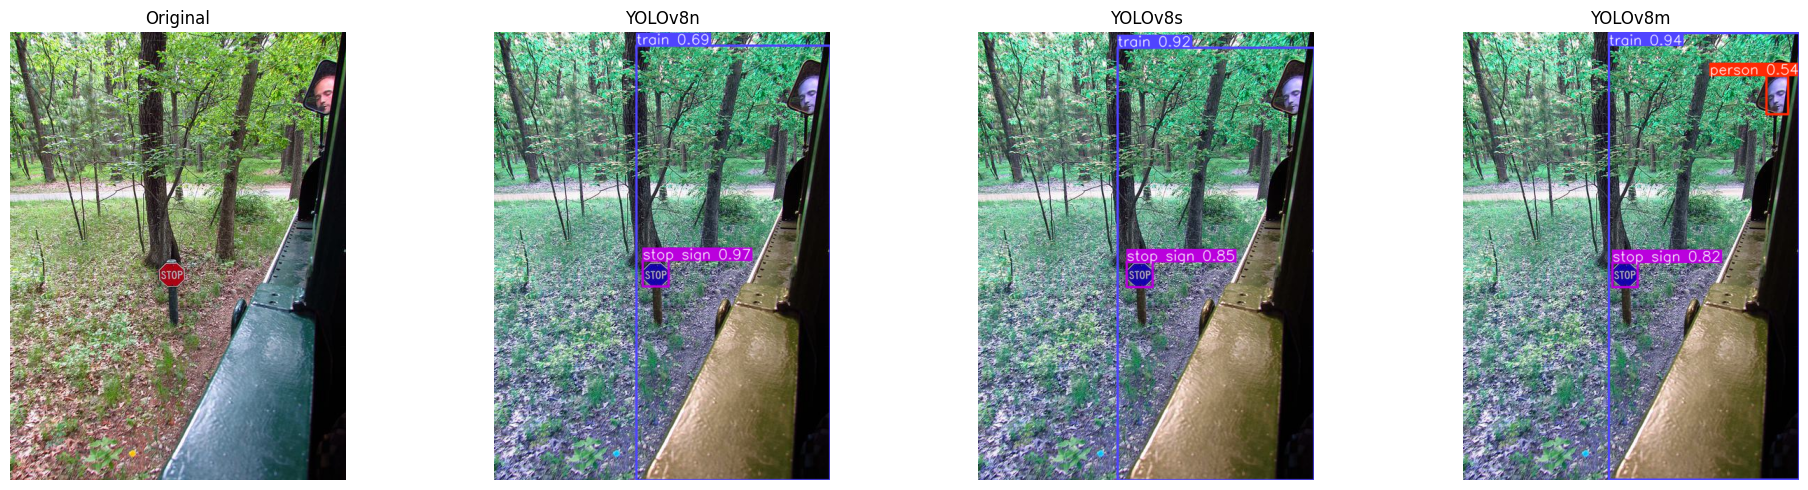


Procesando imagen: 000000000650.jpg
YOLOv8n: 2 detecciones
YOLOv8s: 2 detecciones
YOLOv8m: 2 detecciones


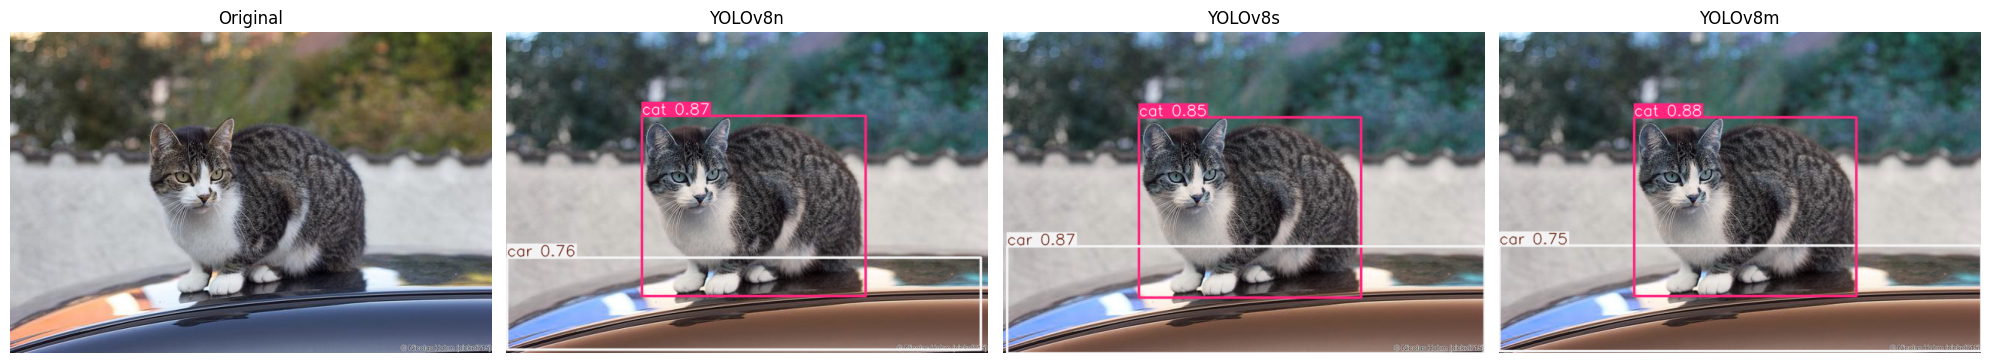


Procesando imagen: 000000000508.jpg
YOLOv8n: 0 detecciones
YOLOv8s: 0 detecciones
YOLOv8m: 0 detecciones


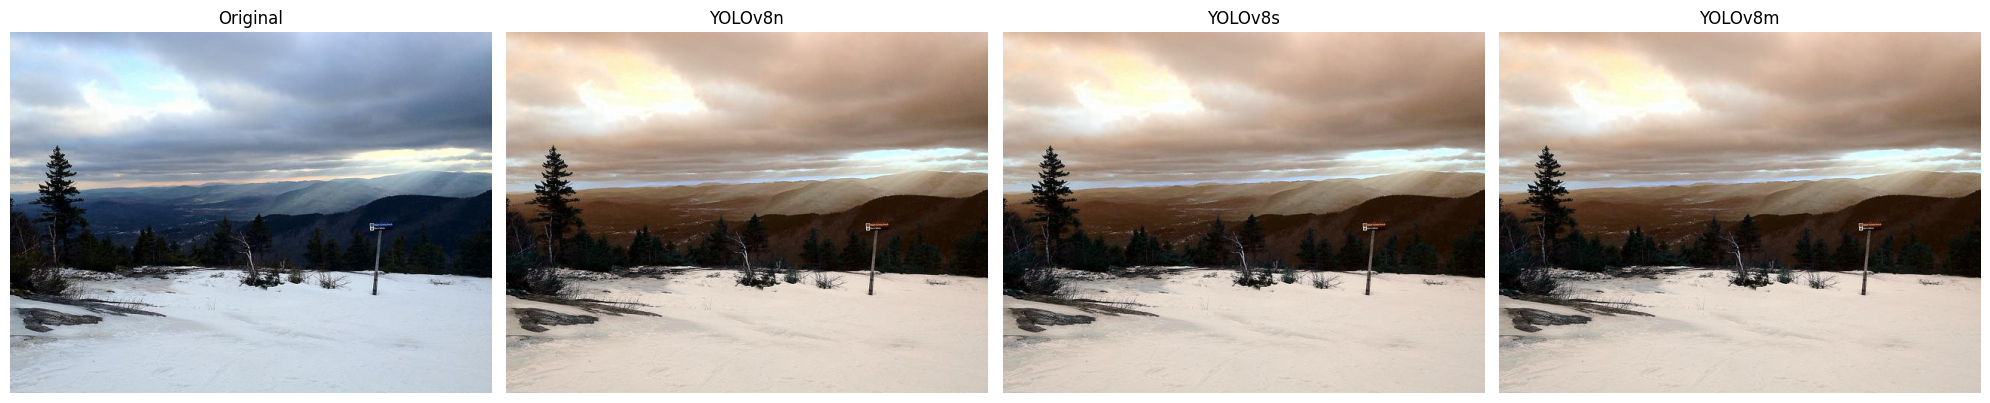


Procesando imagen: 000000000641.jpg
YOLOv8n: 2 detecciones
YOLOv8s: 1 detecciones
YOLOv8m: 2 detecciones


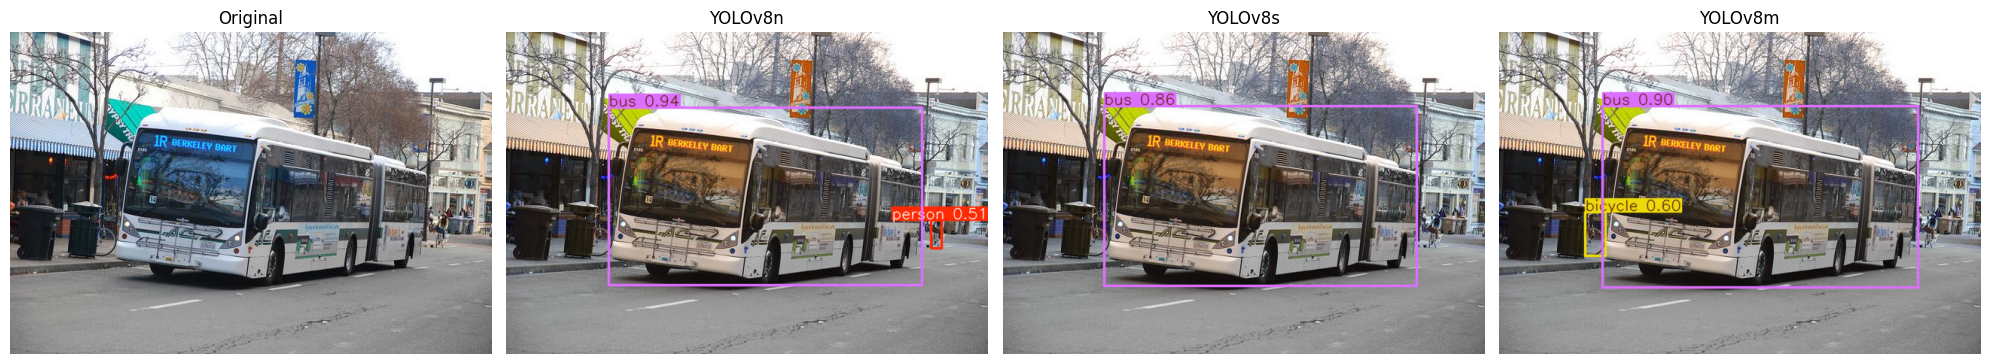


Procesando imagen: 000000000612.jpg
YOLOv8n: 8 detecciones
YOLOv8s: 8 detecciones
YOLOv8m: 7 detecciones


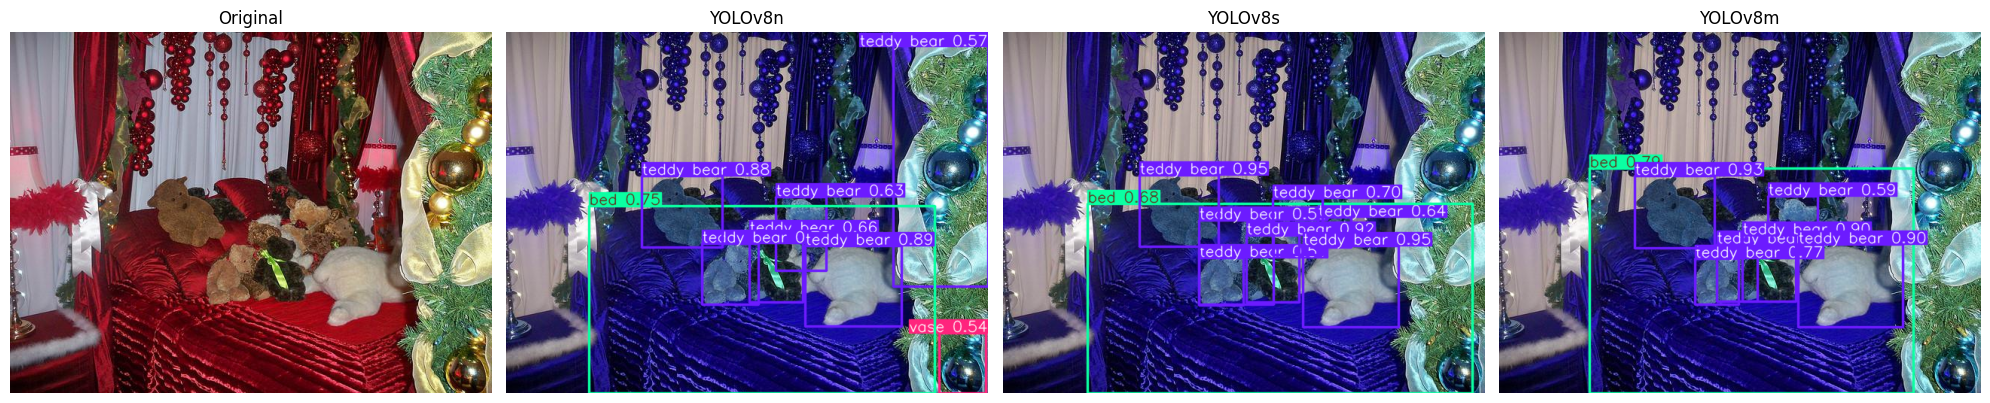


TABLA COMPARATIVA FINAL

RESULTADOS COMPARATIVOS:
         mAP@0.5  mAP@[.5:.95]  Precision  Recall  Velocidad_Inferencia                                    Descripción
YOLOv8n   0.6622        0.4912     0.6565  0.6045               15.5630      Modelo nano - más rápido, menor precisión
YOLOv8s   0.7949        0.6171     0.8197  0.6939               18.0556  Modelo small - equilibrio velocidad/precisión
YOLOv8m   0.8234        0.6558     0.8019  0.7392               15.2534     Modelo medium - mayor precisión, más lento

ANÁLISIS DE RESULTADOS
Mejor mAP@0.5: YOLOv8m (0.8234)
Mejor velocidad: YOLOv8s (18.06 img/seg)
Mejor mAP general: YOLOv8m (0.6558)

CONCLUSIÓN

MODELO GANADOR: YOLOv8m

CRITERIO: Se selecciona basado en mAP@[.5:.95] que es la métrica más robusta
para evaluación de detección de objetos, ya que considera múltiples umbrales IoU.

RESULTADOS CLAVE:
- YOLOv8m: mAP@[.5:.95] = 0.6558
- Velocidad: 15.25 img/seg
- Precision: 0.8019
- Recall: 0.7392



In [ ]:
# =============================================================================
# 6. INFERENCIA DE EJEMPLO (capturas obligatorias)
# =============================================================================

print("\n" + "="*50)
print("INFERENCIA DE EJEMPLO")
print("="*50)

# Seleccionar 5 imágenes de test para mostrar detecciones
test_images = [os.path.join(train_path, img) for img in os.listdir(train_path)[:5]]

# Realizar inferencia con cada modelo en las imágenes seleccionadas
for img_idx, img_path in enumerate(test_images):
    img_name = os.path.basename(img_path)
    print(f"\nProcesando imagen: {img_name}")

    # Cargar imagen original
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Mostrar imagen original
    axes[0].imshow(img_rgb)
    axes[0].set_title('Original', fontsize=12)
    axes[0].axis('off')

    # Inferencia con cada modelo
    for i, (model_name, model) in enumerate(models_dict.items(), 1):
        results = model.predict(img_path, verbose=False, conf=0.5)

        # Dibujar detecciones
        annotated_img = results[0].plot()

        axes[i].imshow(annotated_img)
        axes[i].set_title(f'{model_name}', fontsize=12)
        axes[i].axis('off')

        # Mostrar información de detecciones
        detections = len(results[0].boxes) if results[0].boxes is not None else 0
        print(f"{model_name}: {detections} detecciones")

    plt.tight_layout()
    plt.savefig(f'results/figures/inference_example_{img_idx+1}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Crear tabla comparativa
print("\n" + "="*50)
print("TABLA COMPARATIVA FINAL")
print("="*50)

# Crear DataFrame con resultados
df_results = pd.DataFrame(evaluation_results).T

# Añadir información adicional
model_info = {
    'YOLOv8n': 'Modelo nano - más rápido, menor precisión',
    'YOLOv8s': 'Modelo small - equilibrio velocidad/precisión',
    'YOLOv8m': 'Modelo medium - mayor precisión, más lento'
}

df_results['Descripción'] = [model_info[model] for model in df_results.index]

# Reordenar columnas
columns_order = ['mAP@0.5', 'mAP@[.5:.95]', 'Precision', 'Recall', 'Velocidad_Inferencia', 'Descripción']
df_results = df_results[columns_order]

# Mostrar tabla
print("\nRESULTADOS COMPARATIVOS:")
print("="*80)
print(df_results.to_string(float_format='%.4f'))

# Determinar el mejor modelo
print("\n" + "="*50)
print("ANÁLISIS DE RESULTADOS")
print("="*50)

best_map50 = df_results['mAP@0.5'].idxmax()
best_speed = df_results['Velocidad_Inferencia'].idxmax()
best_overall = df_results['mAP@[.5:.95]'].idxmax()

print(f"Mejor mAP@0.5: {best_map50} ({df_results.loc[best_map50, 'mAP@0.5']:.4f})")
print(f"Mejor velocidad: {best_speed} ({df_results.loc[best_speed, 'Velocidad_Inferencia']:.2f} img/seg)")
print(f"Mejor mAP general: {best_overall} ({df_results.loc[best_overall, 'mAP@[.5:.95]']:.4f})")

# Conclusión
print("\n" + "="*50)
print("CONCLUSIÓN")
print("="*50)

print(f"""
MODELO GANADOR: {best_overall}

CRITERIO: Se selecciona basado en mAP@[.5:.95] que es la métrica más robusta
para evaluación de detección de objetos, ya que considera múltiples umbrales IoU.

RESULTADOS CLAVE:
- {best_overall}: mAP@[.5:.95] = {df_results.loc[best_overall, 'mAP@[.5:.95]']:.4f}
- Velocidad: {df_results.loc[best_overall, 'Velocidad_Inferencia']:.2f} img/seg
- Precision: {df_results.loc[best_overall, 'Precision']:.4f}
- Recall: {df_results.loc[best_overall, 'Recall']:.4f}
""")

##7. Guardado de resultados (figuras/tablas en /results)

In [9]:
# =============================================================================
# 7. GUARDADO DE RESULTADOS (figuras/tablas en /results)
# =============================================================================

print("\n" + "="*50)
print("GUARDANDO RESULTADOS FINALES")
print("="*50)

# Guardar tabla comparativa en CSV
df_results.to_csv('results/tables/tabla_comparativa.csv', float_format='%.4f')
print("✓ Tabla comparativa guardada: results/tables/tabla_comparativa.csv")

# Guardar métricas finales en JSON
final_results = {
    'evaluation_results': evaluation_results,
    'training_times': training_times,
    'best_model': {
        'name': best_overall,
        'mAP_05': float(df_results.loc[best_overall, 'mAP@0.5']),
        'mAP_05_095': float(df_results.loc[best_overall, 'mAP@[.5:.95]']),
        'precision': float(df_results.loc[best_overall, 'Precision']),
        'recall': float(df_results.loc[best_overall, 'Recall']),
        'speed': float(df_results.loc[best_overall, 'Velocidad_Inferencia'])
    }
}

with open('results/final_results.json', 'w') as f:
    json.dump(final_results, f, indent=4)
print("✓ Métricas finales guardadas: results/final_results.json")

# Resumen de archivos generados
print("\n" + "="*50)
print("ARCHIVOS GENERADOS EN /results")
print("="*50)

print(" results/figures/")
print("  ├── metricas_comparativas.png")
print("  ├── velocidad_vs_precision.png")
print("  ├── inference_example_1.png")
print("  ├── inference_example_2.png")
print("  ├── inference_example_3.png")
print("  ├── inference_example_4.png")
print("  └── inference_example_5.png")

print("\n results/tables/")
print("  └── tabla_comparativa.csv")

print("\n results/")
print("  └── final_results.json")

print("\n" + "="*50)
print("PROYECTO COMPLETADO EXITOSAMENTE")
print("="*50)

print(f"""
RESUMEN FINAL:
✓ 3 modelos entrenados: YOLOv8n, YOLOv8s, YOLOv8m
✓ 5 métricas evaluadas: mAP@0.5, mAP@[.5:.95], Precision, Recall, Velocidad
✓ Gráficos comparativos generados
✓ 5 ejemplos de inferencia capturados
✓ Tabla comparativa creada
✓ Modelo ganador identificado: {best_overall}
✓ Todos los resultados guardados en /results

El código está listo para ser usado en el informe PDF.
""")


GUARDANDO RESULTADOS FINALES
✓ Tabla comparativa guardada: results/tables/tabla_comparativa.csv
✓ Métricas finales guardadas: results/final_results.json

ARCHIVOS GENERADOS EN /results
 results/figures/
  ├── metricas_comparativas.png
  ├── velocidad_vs_precision.png
  ├── inference_example_1.png
  ├── inference_example_2.png
  ├── inference_example_3.png
  ├── inference_example_4.png
  └── inference_example_5.png

 results/tables/
  └── tabla_comparativa.csv

 results/
  └── final_results.json

PROYECTO COMPLETADO EXITOSAMENTE

RESUMEN FINAL:
✓ 3 modelos entrenados: YOLOv8n, YOLOv8s, YOLOv8m
✓ 5 métricas evaluadas: mAP@0.5, mAP@[.5:.95], Precision, Recall, Velocidad
✓ Gráficos comparativos generados
✓ 5 ejemplos de inferencia capturados
✓ Tabla comparativa creada
✓ Modelo ganador identificado: YOLOv8m
✓ Todos los resultados guardados en /results

El código está listo para ser usado en el informe PDF.

